In [9]:
import copy
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [10]:
from pydrake.geometry import (
    ClippingRange,
    ColorRenderCamera,
    DepthRange,
    DepthRenderCamera,
    MakeRenderEngineVtk,
    RenderCameraCore,
    RenderEngineVtkParams,
    RenderLabel,
    Role,
    StartMeshcat,
)
from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.multibody.tree import BodyIndex
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.sensors import (
    CameraInfo,
    RgbdSensor,
)
from pydrake.visualization import (
    AddDefaultVisualization,
    ColorizeDepthImage,
    ColorizeLabelImage,
)

In [11]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [12]:
def xyz_rpy_deg(xyz, rpy_deg):
    """Shorthand for defining a pose."""
    rpy_deg = np.asarray(rpy_deg)
    return RigidTransform(RollPitchYaw(rpy_deg * np.pi / 180), xyz)

In [13]:
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0)

In [14]:
iiwa_url = (
   "package://drake/manipulation/models/iiwa_description/sdf/"
   "iiwa14_no_collision.sdf"
)

In [15]:
(left_iiwa,) = Parser(plant, "left").AddModels(url=iiwa_url)
plant.WeldFrames(
    frame_on_parent_F=plant.world_frame(),
    frame_on_child_M=plant.GetFrameByName("iiwa_link_0", left_iiwa),
    X_FM=xyz_rpy_deg([0, -0.5, 0], [0, 0, 0]),
)

<WeldJoint name='world_welds_to_iiwa_link_0' index=7 model_instance=2>

In [16]:
(right_iiwa,) = Parser(plant, "right").AddModels(url=iiwa_url)
plant.WeldFrames(
    frame_on_parent_F=plant.world_frame(),
    frame_on_child_M=plant.GetFrameByName("iiwa_link_0", right_iiwa),
    X_FM=xyz_rpy_deg([0, 0.5, 0], [0, 0, 0]),
)

<WeldJoint name='world_welds_to_iiwa_link_0' index=15 model_instance=3>

In [17]:
# Add a mesh from https://github.com/RobotLocomotion/models/ directly, without
# using the SDFormat wrapper file.
sugar_box_url = "package://drake_models/ycb/meshes/004_sugar_box_textured.obj"
(sugar_box,) = Parser(plant).AddModels(url=sugar_box_url)
sugar_box_body = plant.GetBodyByName("004_sugar_box_textured", sugar_box)
plant.SetDefaultFreeBodyPose(sugar_box_body, xyz_rpy_deg([0, 0, 0.5], [0, 0, 0]))

In [18]:
renderer_name = "renderer"
scene_graph.AddRenderer(
    renderer_name, MakeRenderEngineVtk(RenderEngineVtkParams()))

In [19]:
# N.B. These properties are chosen arbitrarily.
intrinsics = CameraInfo(
    width=640,
    height=480,
    fov_y=np.pi/4,
)
core = RenderCameraCore(
    renderer_name,
    intrinsics,
    ClippingRange(0.01, 10.0),
    RigidTransform(),
)
color_camera = ColorRenderCamera(core, show_window=False)
depth_camera = DepthRenderCamera(core, DepthRange(0.01, 10.0))

In [20]:
world_id = plant.GetBodyFrameIdOrThrow(plant.world_body().index())
X_WB = xyz_rpy_deg([2, 0, 0.75], [-90, 0, 90])
sensor = RgbdSensor(
    world_id,
    X_PB=X_WB,
    color_camera=color_camera,
    depth_camera=depth_camera,
)

builder.AddSystem(sensor)
builder.Connect(
    scene_graph.get_query_output_port(),
    sensor.query_object_input_port(),
)

In [21]:
colorize_depth = builder.AddSystem(ColorizeDepthImage())
colorize_label = builder.AddSystem(ColorizeLabelImage())
colorize_label.background_color.set([0,0,0])
builder.Connect(sensor.GetOutputPort("depth_image_32f"),
                colorize_depth.GetInputPort("depth_image_32f"))
builder.Connect(sensor.GetOutputPort("label_image"),
                colorize_label.GetInputPort("label_image"))

In [22]:
plant.Finalize()

In [23]:
AddDefaultVisualization(builder=builder, meshcat=meshcat)

In [1]:
diagram = builder.Build()
diagram_context = diagram.CreateDefaultContext()


NameError: name 'builder' is not defined

In [25]:
Simulator(diagram).Initialize()

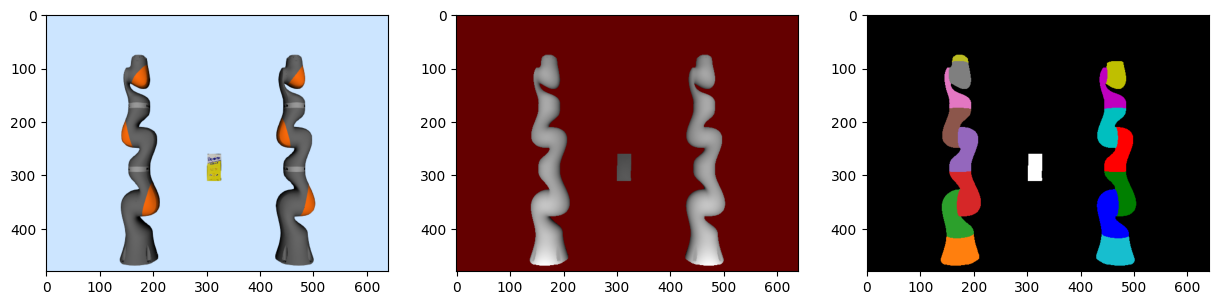

In [26]:
color = sensor.color_image_output_port().Eval(
    sensor.GetMyContextFromRoot(diagram_context)).data
depth = colorize_depth.get_output_port().Eval(
    colorize_depth.GetMyContextFromRoot(diagram_context)).data
label = colorize_label.get_output_port().Eval(
    colorize_label.GetMyContextFromRoot(diagram_context)).data

fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(color)
ax[1].imshow(depth)
ax[2].imshow(label)

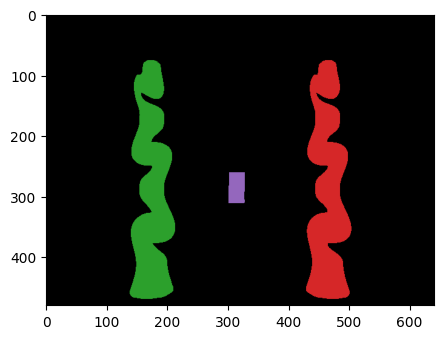

In [27]:
source_id = plant.get_source_id()
scene_graph_context = scene_graph.GetMyMutableContextFromRoot(diagram_context)
query_object = scene_graph.get_query_output_port().Eval(scene_graph_context)
inspector = query_object.inspector()
for geometry_id in inspector.GetAllGeometryIds():
    properties = copy.deepcopy(inspector.GetPerceptionProperties(geometry_id))
    if properties is None:
        continue
    frame_id = inspector.GetFrameId(geometry_id)
    body = plant.GetBodyFromFrameId(frame_id)
    new_label = int(body.model_instance())
    properties.UpdateProperty("label", "id", RenderLabel(new_label))
    # TODO(#19123) Ideally we would use AssignRole(..., kReplace) here,
    # but it is not yet supported for perception properties.
    scene_graph.RemoveRole(scene_graph_context, source_id, geometry_id, Role.kPerception)
    scene_graph.AssignRole(scene_graph_context, source_id, geometry_id, properties)

label = colorize_label.get_output_port().Eval(
    colorize_label.GetMyContextFromRoot(diagram_context)).data
plt.figure(figsize=(5, 5))
plt.imshow(label)

In [38]:
from IPython.display import SVG, display
import pydot

In [39]:
display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

FileNotFoundError: [Errno 2] "dot" not found in path.

pydrake.multibody.plant.MultibodyPlant